# Obiettivi
## 1. Analisi Descrittiva dei Contenuti

Il primo obiettivo del progetto è condurre un'analisi esplorativa dei dati (EDA) per capire le caratteristiche dei contenuti di Wikipedia suddivisi in diverse categorie tematiche, come ad esempio: - Cultura, Economia, Medicina, Tecnologia, Politica, Scienza, e altre.

L'analisi esplorativa prevede: - Il conteggio degli articoli presenti per ogni categoria. - Il numero medio di parole per articolo. - La lunghezza dell'articolo più lungo e di quello più corto per ciascuna categoria. - La creazione di nuvole di parole rappresentative per ogni categoria, per identificare i termini più frequenti e rilevanti.

## 2. Sviluppo di un Classificatore Automatico

Il secondo obiettivo è creare un modello di machine learning capace di classificare automaticamente gli articoli in base alla loro categoria. Il sistema di classificazione verrà addestrato utilizzando dati di testo presenti nelle seguenti colonne del dataset: - Sommario (summary): Introduzione breve dell'articolo. - Testo Completo (documents): Contenuto completo dell'articolo.

## 3. Identificazione di Nuovi Insights

L'analisi consentirà anche di ottenere preziosi insights sui contenuti di Wikipedia, come la densità di articoli per categoria o le tendenze linguistiche associate a determinati argomenti. Queste informazioni possono aiutare Wikimedia a migliorare l'organizzazione delle pagine e a ottimizzare i propri sforzi editoriali.

In [0]:
%pip install wordcloud

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install langdetect

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd

# graphic modules
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from langdetect import detect

# pyspark SQL
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, min, max,avg, round,concat_ws,regexp_replace, lower,expr,udf
from pyspark.sql.types import StringType
# pyspark ML
from pyspark.ml.feature import CountVectorizer, StringIndexer,StandardScaler,Tokenizer, StopWordsRemover
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# IMPORTAZIONE DEL DATASET

## Conversione in Spark dataframe

In [0]:
# Initialize SparkSession if not already active
spark = SparkSession.builder.appName("Wikipedia_Analysis").getOrCreate()

In [0]:
spark_df = spark.read.table("workspace.default.wikipedia")

# ANALISI DEL DATASET

## Visualizazione contenuto e tipo dati

In [0]:
spark_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- categoria: string (nullable = true)



In [0]:
spark_df.show(10)


+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|    foxhall p. keene|foxhall parker ke...|foxhall parker ke...|   sports|
|thomas william ki...|thomas william ki...|thomas william ki...|   sports|
|    rene la montagne|rene morgan la mo...|rene morgan la mo...|   sports|
|         lewis lacey|lewis lawrence la...|lewis lawrence la...|   sports|
| malcolm orme little|brigadier-general...|brigadier-general...|   sports|
| john hardress-lloyd|brigadier-general...|brigadier-general...|   sports|
|      vivian lockett|vivian noverre lo...|vivian noverre lo...|   sports|
|         tim melvill|teignmouth philip...|teignmouth philip...|   sports|
|    devereux milburn|devereux milburn ...|devereux milburn ...|   sports|
|charles darley mi...|charles darley mi...|charles darley mi...|   sports|
+--------------------+---

## Distribuzione delle categorie degli articoli

In [0]:
spark_df.createOrReplaceTempView("wikipedia_articles")

category_counts = spark.sql("SELECT categoria, COUNT(*) AS numero_articoli FROM wikipedia_articles GROUP BY categoria ORDER BY numero_articoli DESC")

category_counts.show(truncate=False)

+-----------+---------------+
|categoria  |numero_articoli|
+-----------+---------------+
|politics   |11358          |
|culture    |10372          |
|science    |10236          |
|humanities |10236          |
|engineering|10220          |
|finance    |10157          |
|transport  |10130          |
|economics  |10110          |
|technology |10095          |
|medicine   |10076          |
|sports     |10068          |
|trade      |10068          |
|energy     |10046          |
|research   |10037          |
|pets       |10023          |
+-----------+---------------+



Le **categorie** sono equamente distribuite all'interno dei vari articoli

## Rappresentazione occorenze delle categorie negli articoli

In [0]:
# Create a dictionary of category frequencies
category_frequency = {row['categoria']: row['numero_articoli'] for row in category_counts.collect()}

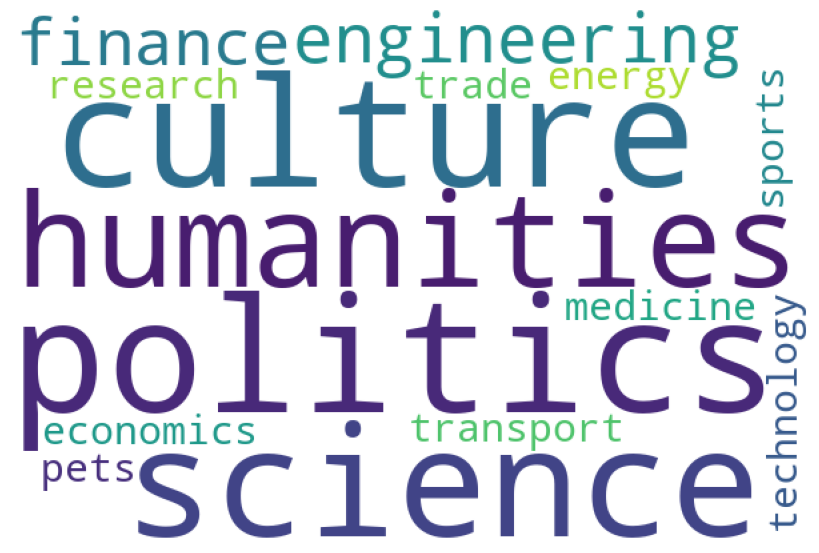

In [0]:
# Generate the word cloud
wordcloud = WordCloud(
    width = 600, height = 400,
    background_color ='white',
    min_font_size = 10).generate_from_frequencies(category_frequency)

# Display the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Analisi della lunghezza degli articoli per categoria

In [0]:
## Add column with length of documents
spark_df = spark_df.withColumn("document_length", length(spark_df["documents"]))

In [0]:
avg_length = spark_df.select(round(avg("document_length"))).collect()[0][0]

print('La lungheza media degli articoli è di: ' + str(avg_length) + ' caratteri')

La lungheza media degli articoli è di: 5881.0 caratteri


In [0]:
spark_df.groupBy("categoria").agg(
    min("document_length").alias("Min length"),
    max("document_length").alias("Max length"),
    round(avg("document_length")).alias("Average length")
).show(truncate=False)

+-----------+----------+----------+--------------+
|categoria  |Min length|Max length|Average length|
+-----------+----------+----------+--------------+
|research   |116       |158762    |4644.0        |
|medicine   |76        |119361    |5104.0        |
|engineering|50        |77579     |4537.0        |
|sports     |90        |115092    |3621.0        |
|science    |81        |177114    |11803.0       |
|transport  |57        |135535    |3893.0        |
|technology |29        |115154    |5592.0        |
|humanities |56        |135319    |6619.0        |
|finance    |7         |190204    |11724.0       |
|trade      |100       |121240    |3950.0        |
|pets       |71        |81386     |2585.0        |
|energy     |60        |146236    |3703.0        |
|culture    |70        |102337    |4064.0        |
|economics  |67        |150009    |6339.0        |
|politics   |77        |128393    |9614.0        |
+-----------+----------+----------+--------------+



# SVILUPPO DI UN CLASSIFICATORE AUTOMATICO

### Creazione unica colonna con tutto il testo da analizzare

In [0]:
# Combine 'title', 'summary', and 'documents' columns into a new column 'combined_text'
spark_df = spark_df.withColumn(
    "combined_text",
    concat_ws(" ", spark_df["title"], spark_df["summary"], spark_df["documents"])
)

## Creazione del dataset di test e di training

In [0]:
train,test = spark_df.randomSplit([0.7,0.3], seed=0)

In [0]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 107274
Test Dataset Count: 45958


## Preparazione dataset di training

In [0]:
# Remove parentheses, punctuation, numbers, and special characters from combined_text
train = train.withColumn(
    "clean_text",
    lower(regexp_replace(train["combined_text"], r"[\(\)\[\]\{\},.;:'\"!?@#$%^&*_+=<>|\\/~`0-9]", ""))
)

In [0]:
# Tokenize the combined_text column
tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
#train_tokenized = tokenizer.transform(train)

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"]
# Remove stop words
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens").setStopWords(add_stopwords)
#train_no_stopwords = remover.transform(train_tokenized)

In [0]:
pipelineData = Pipeline(stages=[tokenizer, remover])

In [0]:
pipelineDataFit = pipelineData.fit(train)
train_no_stopwords = pipelineDataFit.transform(train)

In [0]:
# Remove empty elements from filtered_tokens
train_no_stopwords = train_no_stopwords.withColumn(
    "filtered_tokens",
    expr("filter(filtered_tokens, x -> x != '')")
)

## Creazione pipeline e addestramento del modello

In [0]:
# Convert filtered tokens to feature vectors
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vector", vocabSize = 7000, minDF=0.01,maxDF=0.7)
# Scale the feature vectors
scaler = StandardScaler(inputCol="vector",outputCol="features")

# Index the target column
label_indexer = StringIndexer(inputCol="categoria", outputCol="label")

# Build pipeline
pipeline = Pipeline(stages=[vectorizer, scaler, label_indexer])

In [0]:
pipelineFit = pipeline.fit(train_no_stopwords)
dataset = pipelineFit.transform(train_no_stopwords)

### Logistic regretion model

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [0]:
lrModel = lr.fit(dataset)

### Random forest model

In [0]:
# Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth = 4,
                            maxBins = 32)

In [0]:
rfModel = rf.fit(dataset)

## Predizioni

In [0]:
test_clean = test.withColumn(
    "clean_text",
    lower(regexp_replace(test["combined_text"], r"[\(\)\[\]\{\},.;:'\"!?@#$%^&*_+=<>|\\/~`0-9]", ""))
)

In [0]:
# Transform the test set using the fitted pipeline to generate 'features' and 'label'
test_no_stopword = pipelineDataFit.transform(test_clean)

In [0]:
test_dataset = pipelineFit.transform(test_no_stopword)

In [0]:
rfPredictions = rfModel.transform(test_dataset)

display(rfPredictions.select("combined_text", "label", "prediction"))

combined_text label prediction maria magdalena "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. background and release the song was composed by hubert kemmler, markus löhr and michael cretu. cretu also arranged and produced the song. the lyrics were written by richard palmer-james. the allusion to the biblical figure mary magdalene was kemmler's idea and came up when a name with seven syllables was needed for the chorus. only the german version of the name would suffice, though, "mary magdalene" has five. kemmler also provided co-lead vocals on this recording and a number of sandra's subsequent songs. the song was first released in march 1985 as the lead single from sandra's debut album the long play. it was her third single as a solo artist, but the first solo single to be released internationally. initially unsuccessful in its bid to gain radio play, the label targeted djs in greece and their tourist audiences next, and the song subsequently became a big hit in greece, where it topped the singles chart. returning tourists requested the song at home, and it eventually reached number one on the official german singles chart for four consecutive weeks between 13 september and 4 october 1985. the single then peaked at number one in austria, switzerland, sweden, norway, the netherlands and finland. it also reached number 1 on the airplay chart in germany as well as the top 5 in austria. in the pan-european charts, it was a top 10 and a top 20 hit on the airplay and sales charts, respectively.the song was re-released in a remixed version as a standalone single in 1993, but was not commercially successful, though it reached the top ten in finland and the top twenty in denmark. music website allmusic retrospectively rated it 2.5 out of 5 stars. in 1999, another remix of the song was released only in france as a promotional single in support of her compilation album my favourites. the track was remixed again for her remix album reflections (2006), and the original version was later sampled in the song "kings & queens" on her tenth album stay in touch (2012). music videos a simple performance music video was filmed in 1985, which presents sandra accompanied by a bassist/backing vocalist, a percussionist and a keyboardist. it was directed by mike leckebusch. the music video was released on sandra's vhs video compilations ten on one (the singles) and 18 greatest hits, released in 1987 and 1992, respectively, as well as the 2003 dvd the complete history.the industrial style video for the 1993 version was directed by marcus adams, and was also released on the complete history dvd. track listing and formats 7-inch vinyl singlea. "(i'll never be) maria magdalena" – 3:58 b. "party games" (instrumental) – 3:2512-inch vinyl singlea. "(i'll never be) maria magdalena" – 7:13 b. "party games" (instrumental) – 3:25cd maxi-single (1993)"maria magdalena" (radio edit) – 3:58 "maria magdalena" (clubmix) – 6:01 "maria magdalena" (original version) – 3:5812-inch vinyl single (1993)a. "maria magdalena" (clubmix) – 6:01 b. "maria magdalena" (vega sicilia mix) – 5:3612-inch vinyl single (1999)a. "maria m

In [0]:
lrPredictions = lrModel.transform(test_dataset)

display(lrPredictions.select("combined_text", "label", "prediction"))

combined_text label prediction maria magdalena "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. background and release the song was composed by hubert kemmler, markus löhr and michael cretu. cretu also arranged and produced the song. the lyrics were written by richard palmer-james. the allusion to the biblical figure mary magdalene was kemmler's idea and came up when a name with seven syllables was needed for the chorus. only the german version of the name would suffice, though, "mary magdalene" has five. kemmler also provided co-lead vocals on this recording and a number of sandra's subsequent songs. the song was first released in march 1985 as the lead single from sandra's debut album the long play. it was her third single as a solo artist, but the first solo single to be released internationally. initially unsuccessful in its bid to gain radio play, the label targeted djs in greece and their tourist audiences next, and the song subsequently became a big hit in greece, where it topped the singles chart. returning tourists requested the song at home, and it eventually reached number one on the official german singles chart for four consecutive weeks between 13 september and 4 october 1985. the single then peaked at number one in austria, switzerland, sweden, norway, the netherlands and finland. it also reached number 1 on the airplay chart in germany as well as the top 5 in austria. in the pan-european charts, it was a top 10 and a top 20 hit on the airplay and sales charts, respectively.the song was re-released in a remixed version as a standalone single in 1993, but was not commercially successful, though it reached the top ten in finland and the top twenty in denmark. music website allmusic retrospectively rated it 2.5 out of 5 stars. in 1999, another remix of the song was released only in france as a promotional single in support of her compilation album my favourites. the track was remixed again for her remix album reflections (2006), and the original version was later sampled in the song "kings & queens" on her tenth album stay in touch (2012). music videos a simple performance music video was filmed in 1985, which presents sandra accompanied by a bassist/backing vocalist, a percussionist and a keyboardist. it was directed by mike leckebusch. the music video was released on sandra's vhs video compilations ten on one (the singles) and 18 greatest hits, released in 1987 and 1992, respectively, as well as the 2003 dvd the complete history.the industrial style video for the 1993 version was directed by marcus adams, and was also released on the complete history dvd. track listing and formats 7-inch vinyl singlea. "(i'll never be) maria magdalena" – 3:58 b. "party games" (instrumental) – 3:2512-inch vinyl singlea. "(i'll never be) maria magdalena" – 7:13 b. "party games" (instrumental) – 3:25cd maxi-single (1993)"maria magdalena" (radio edit) – 3:58 "maria magdalena" (clubmix) – 6:01 "maria magdalena" (original version) – 3:5812-inch vinyl single (1993)a. "maria magdalena" (clubmix) – 6:01 b. "maria magdalena" (vega sicilia mix) – 5:3612-inch vinyl single (1999)a. "maria m

## Valutazione delle performance

In [0]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy')

### Performance Random Forest

In [0]:
evaluator.evaluate(rfPredictions)

0.6974629009095261

### Performance Logisti regression

In [0]:
evaluator.evaluate(lrPredictions)

0.8699247138691849

# Risultato valutazione modelli
La Logistic Regression raggiunge un'accuratezza di 0.87, superando il Random Forest che si ferma a 0.69. il Random Forest è generalmente un metodo ensemble robusto e versatile, ma tende ad avere difficoltà con dati sparsi ad alta dimensionalità, come i vettori bag-of-words tipici dei task di classificazione del testo.
La Logistic Regression, al contrario, è particolarmente adatta a questo tipo di dati in quanto gestisce in modo efficiente input sparsi ad alta dimensionalità e beneficia della separabilità lineare che spesso caratterizza le feature testuali dopo la vettorizzazione.
Sulla base di questi risultati, la Logistic Regression è il modello con le migliori prestazioni per questo esperimento e verrà selezionata come classificatore finale.

# RICONOSCIMENTO DELLE LINGUE

In [0]:
# UDF to detect language
detect_language_udf = udf(lambda text: detect(text) if text else None, StringType())

# Add language column to test_dataset
spark_df = spark_df.withColumn("language", detect_language_udf(spark_df["combined_text"]))



In [0]:
display(spark_df.select("combined_text", "language").limit(5))

combined_text language irvine page irvine heinly page (january 7, 1901 – june 10, 1991) was an american physiologist who played an important part in the field of hypertension for almost 60 years while working at the cleveland clinic as the first chair of research. irvine heinly page (january 7, 1901 – june 10, 1991) was an american physiologist who played an important part in the field of hypertension for almost 60 years while working at the cleveland clinic as the first chair of research. early life and education irvine page was born on january 7, 1901, in indianapolis, indiana. he attended college at cornell university, with an undergraduate degree in chemistry (1921) and an m.d. degree in 1926. page completed his internship at presbyterian and bellevue hospitals in new york city. career after completing his internship, page then performed research in physical chemistry at woods hole and then new york. in 1928 he joined the kaiser wilhelm institute in munich, germany where he started a new department of neurochemistry. with the coming rise to power of hitler, page left munich in 1931 to work with donald van slyke at the rockefeller institute for medical research in new york city. he worked at the rockefeller institute through 1937. page then moved back to indianapolis as director of the laboratory for clinical research at eli lilly at city hospital. in 1945, page then organized a new research division at the cleveland clinic.his first contributions were published in the early 1930s and his most recent, "hypertension research: a memoir: 1920–1960", in 1988. he is perhaps best known for the co-discovery of serotonin in 1948, although his pre-eminence is a matter of record in four other areas: the renin–angiotensin system, the mosaic theory of hypertension, treatment of hypertension and public and professional advocacy of the recognition of this condition and its effects in daily life. in earlier work he published on the neurochemistry of the brain. page received many honors for his work. he was on the cover of time magazine in 1955. he was president of the american heart association (1956–57); he received ten honorary degrees and a number of prestigious awards—the ida b. gould memorial award of the american association for the advancement of science (1957); albert lasker award (1958); gairdner foundation international award (1963); distinguished award of the american medical association (1964); oscar b. hunter award (1966); golden plate award of the american academy of achievement (1966); passano foundation award (1967); and the stouffer prize (now the novartis award) for hypertension research in 1970. he was elected to the national academy of sciences in 1971 and published his memoirs in 1988. the american heart association irvine h. page young investigator research award archived 2007-09-27 at the wayback machine and the irvine page – alva bradley lifetime achievement award are named in his honor. later life a collection of his papers is held at the national library of medicine in bethesda, maryland. personal life he was married to beatrice allen, a dancer, poet, and author of the book, the bracelet. his sister was ruth page, a noted american ballet dancer. page was also a gifted musician, a trait he passed on to his two sons, christopher page and nicholas page. page lived in cleveland, oh with his wife and children, summering in hyannis port on cape cod. his family home on the cape is now owned and occupied by his granddaughter and great-grandchildren. death having retired to hyannis port, massachusetts, page died suddenly on june 10, 1991, at the age of 90. he had been previously injured in an auto accident in march 1990 and suffered from poor health due to a prior stroke and a prior heart attack. selected publications page, irvine (1987). hypertension mechanisms. orlando, fla.: grune & stratton. isbn 978-0-8089-1768-7. page, irvine (1988). hypertension research: a memoir : 1920-1960. new york: pergamon. isbn 978-0-08-0360

In [0]:
# Get language frequencies
lang_freq = spark_df.groupBy("language").count().orderBy("count", ascending=False).toPandas()

In [0]:
display(lang_freq)

language count en 152558 fr 109 it 85 id 62 de 55 no 52 da 30 ro 29 tl 29 nl 27 sl 26 sv 24 pt 19 et 18 es 17 sq 17 sk 16 pl 15 lv 10 ca 7 af 5 cy 4 tr 4 hu 3 cs 3 sw 3 so 2 hr 2 ru 1

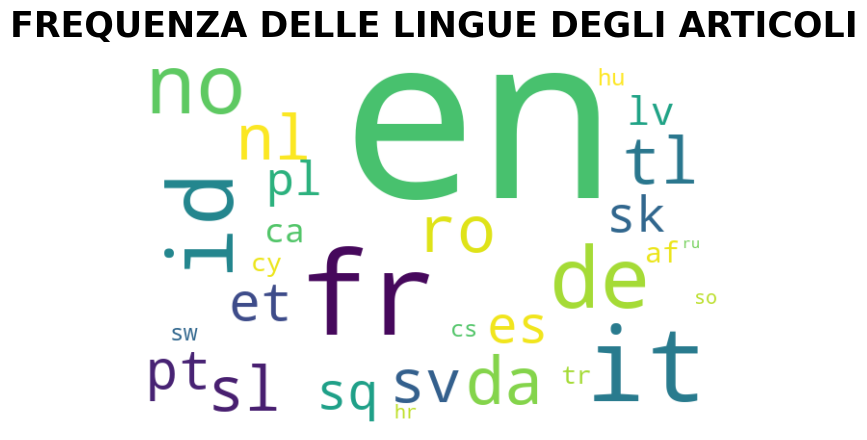

In [0]:
# Create a dictionary of language frequencies
lang_dict = dict(zip(lang_freq['language'], lang_freq['count']))

# Generate word cloud
wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(lang_dict)

plt.figure(figsize=(10, 5))
plt.title('FREQUENZA DELLE LINGUE DEGLI ARTICOLI', fontsize=25, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# BIBLIOGRAFIA
1. [Removing stopwords from text with saprk nlp](https://www.johnsnowlabs.com/text-cleaning-removing-stopwords-from-text-with-spark-nlp/)
2. [Multi class classification](https://medium.com/data-science/multi-class-text-classification-with-pyspark-7d78d022ed35)
3. [Language detector](https://medium.com/@monigrancharov/text-language-detection-with-python-beb49d9667b3)